<a href="https://colab.research.google.com/github/feliciahf/data_science_exam/blob/main/hippocorpus_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Setup

#1.1. Using Colab GPU for Training 

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.
A GPU can be added by going to the menu and selecting:
Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)
Then run the following cell to confirm that the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## 1.2. Installing the Hugging Face Library

Next, let's install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).
At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use BertForSequenceClassification.
The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

In [3]:
!pip install transformers

     |████████████████████████████████| 2.1MB 19.0MB/s 
     |████████████████████████████████| 3.3MB 54.4MB/s 
     |████████████████████████████████| 870kB 51.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e6b63aae831ac583be1cdfcba2988c28fb2a07ff291c1e8848f771e6ca797b4e
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


## 2.1. Download & Extract

We'll use the wget package to download the dataset to the Colab instance's file system.

In [4]:
!pip install PyDrive

In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
import pandas as pd
import numpy as np

In [8]:
# import csv file as dataframe (from GitHub repo)

url = 'https://raw.githubusercontent.com/feliciahf/data_science_exam/main/hippoCorpusV2.csv'
df = pd.read_csv(url, encoding='latin1')

In [9]:
# remove columns with uninformative information (AssignmentId, WorkerId, recAgnPairId, recImgPairId)
uninformative_cols = ["AssignmentId", "WorkerId", "recAgnPairId", "recImgPairId"]
df = df.drop(columns=uninformative_cols)

In [10]:
# make labels column using numerical values
df.memType = pd.Categorical(df.memType)
df['label'] = df.memType.cat.codes

In [11]:
# story type corresponding to label
print(f"Label 0: {df.loc[df['label'] == 0,'memType'].unique()}")
print(f"Label 1: {df.loc[df['label'] == 1,'memType'].unique()}")
print(f"Label 2: {df.loc[df['label'] == 2,'memType'].unique()}")

Label 0: ['imagined']
Categories (1, object): ['imagined']
Label 1: ['recalled']
Categories (1, object): ['recalled']
Label 2: ['retold']
Categories (1, object): ['retold']


In [ ]:
# drop old labels column?

In [ ]:
# columns with NaN values? (no NaN values in "story" column though - so not relevant right now probably)

## Split the dataset into train-test


In [12]:
df['split'] = np.random.randn(df.shape[0],1)

# create mask to split data into 80/20%
msk = np.random.rand(len(df)) <= 0.8

train = df[msk]
test = df[~msk]

train = train.drop(columns=["split"])
test = test.drop(columns=["split"])
df = df.drop(columns=["split"])

#Save the train and test set to csv files

In [ ]:
train.to_csv('train.csv', index=False) 
test.to_csv('test.csv', index=False)

##2.2. Parse



We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we must use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [13]:
# Report the number of titles.
print('Number of participants: {:,}\n'.format(train.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of participants: 5,455



,WorkTimeInSeconds,annotatorAge,annotatorGender,annotatorRace,distracted,draining,frequency,importance,logTimeSinceEvent,mainEvent,memType,mostSurprising,openness,similarity,similarityReason,story,stressful,summary,timeSinceEvent,label
4962,1507,30.0,woman,white,1.0,1.0,4.0,5.0,5.010635,my son's type 1 diabetes diagnosis,recalled,his blood glucose came out to 562.,0.875,NaN,NaN,I will never forget the day my life changed. M...,1.0,My son was diagnosed with type 1 diabetes a fe...,150.0,1
5279,1339,25.0,man,white,1.0,1.0,3.0,5.0,4.499810,Getting a new dog,recalled,Changed my mind about wanting another dog,0.250,NaN,NaN,I recently just got a new dog after 2 years si...,1.0,put my dog to sleep a few years ago and never ...,90.0,1
4471,630,25.0,nonBinary,hisp,4.0,4.0,4.0,5.0,3.044522,my visit to seem y dad.,recalled,My dad didn't know why black hairstyles exist.,1.000,NaN,NaN,"When I went to my dad's house a few weeks ago,...",5.0,I went to visit my family in New York recently...,21.0,1
3843,745,35.0,woman,white,1.0,2.0,2.0,3.0,5.347108,me going to my cousin's wedding,retold,When my aunt vomits on the table,0.625,NaN,NaN,"This past spring, we attended the wedding of m...",2.0,My cousin got married and we were invited afte...,210.0,2
6310,787,35.0,man,white,1.0,1.0,NaN,1.0,4.787492,feeding and petting giraffes at the zoo.,imagined,the giraffe put her head on my shoulder.,0.250,1.0,I don't like zoos or giraffes or animals in ge...,I go to the zoo every month. usually it is ver...,1.0,I had a special day at the zoo. I was able to ...,120.0,0
4965,1311,55.0,woman,black,1.0,1.0,4.0,4.0,2.639057,About the great fundraising efforts of a young...,recalled,I learned of all the lives this person touched.,0.000,NaN,NaN,I attended the memorial service of a remarkabl...,1.0,A young woman who was a member of my church wa...,14.0,1
430,1697,55.0,woman,white,1.0,1.0,5.0,5.0,4.499810,my daughter and son-in-law expecting twin daug...,retold,"she wasn't having a misscarriage, but was expe...",0.375,NaN,NaN,My daughter's pregnancy with twins is progress...,2.0,My daughter and her husband announced the were...,90.0,2
2496,5864,35.0,woman,white,1.0,1.0,NaN,4.0,4.094345,my birthday with my boyfriend.,imagined,he surprised me with a gift.,1.000,3.0,I like doing things on my birthday that are di...,I just celebrated my birthday! You know how I ...,1.0,I something different for my birthday this yea...,60.0,0
6768,3802,30.0,woman,white,2.0,2.0,3.0,4.0,3.401197,how I got fired,recalled,they thought I'd be sad,0.000,NaN,NaN,"Dear Diary, I just got fired! I was called int...",3.0,I was fired over something they claimed I didn...,30.0,1
6773,444,35.0,woman,white,1.0,1.0,5.0,5.0,5.010635,falling in love,recalled,we finally made it offical,0.500,NaN,NaN,About 5 months ago the best thing to ever happ...,1.0,I went to a party with a friend. By the end of...,150.0,1


Let's extract the sentences and labels of our training set as numpy ndarrays.

In [14]:
# Get the lists of stories and their types/labels
stories = train['story'].values # list of all the stories
labels = train['label'].values # list of all the diffrent story types

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.
The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [15]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [16]:
# Print the original story.
print(' Original: ', stories[0])

# Print the story split into tokens.
print('Tokenized: ', tokenizer.tokenize(stories[0]))

# Print the story mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(stories[0])))

 Original:  Concerts are my most favorite thing, and my boyfriend knew it. That's why, for our anniversary, he got me tickets to see my favorite artist. Not only that, but the tickets were for an outdoor show, which I love much more than being in a crowded stadium. Since he knew I was such a big fan of music, he got tickets for himself, and even a couple of my friends. He is so incredibly nice and considerate to me and what I like to do. I will always remember this event and I will always cherish him. On the day of the concert, I got ready, and he picked me up and we went out to a restaurant beforehand. He is so incredibly romantic. He knew exactly where to take me without asking. We ate, laughed, and had a wonderful dinner date before the big event. We arrived at the concert and the music was so incredibly beautiful. I loved every minute of it. My friends, boyfriend, and I all sat down next to each other. As the music was slowly dying down, I found us all getting lost just staring at 

When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

##3.3. Tokenize Dataset

The transformers library provides a helpful encode function which will handle most of the parsing and data prep steps for us.
Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.
The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [17]:
max_len = 512

# For every story...
for story in stories:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens
    input_ids = tokenizer.encode(story, add_special_tokens=True, truncation=True, max_length=max_len)

print('Max story length: ', max_len)

Max story length:  512


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [18]:
# Tokenize all of the titles and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for story in stories:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        story,                      # Story to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True, # truncate to max_length
                        max_length = max_len, 
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded story to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print title 1, now as a list of IDs.
print('Original: ', stories[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Concerts are my most favorite thing, and my boyfriend knew it. That's why, for our anniversary, he got me tickets to see my favorite artist. Not only that, but the tickets were for an outdoor show, which I love much more than being in a crowded stadium. Since he knew I was such a big fan of music, he got tickets for himself, and even a couple of my friends. He is so incredibly nice and considerate to me and what I like to do. I will always remember this event and I will always cherish him. On the day of the concert, I got ready, and he picked me up and we went out to a restaurant beforehand. He is so incredibly romantic. He knew exactly where to take me without asking. We ate, laughed, and had a wonderful dinner date before the big event. We arrived at the concert and the music was so incredibly beautiful. I loved every minute of it. My friends, boyfriend, and I all sat down next to each other. As the music was slowly dying down, I found us all getting lost just staring at t

## 3.4. Training & Validation Split

Divide up our training set to use 80% for training and 20% for validation.

In [19]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8* len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,364 training samples
1,091 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model


## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").
The documentation for from_pretrained can be found here, with the additional parameters defined here.

In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [22]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)...)

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [24]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line.

Define a helper function for calculating accuracy.

In [25]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [26]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


RuntimeError: ignored

Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.49,1.19,0.67,0:56:27,0:05:03
2,1.03,1.12,0.69,0:56:27,0:05:04
3,0.84,1.13,0.69,0:56:26,0:05:04


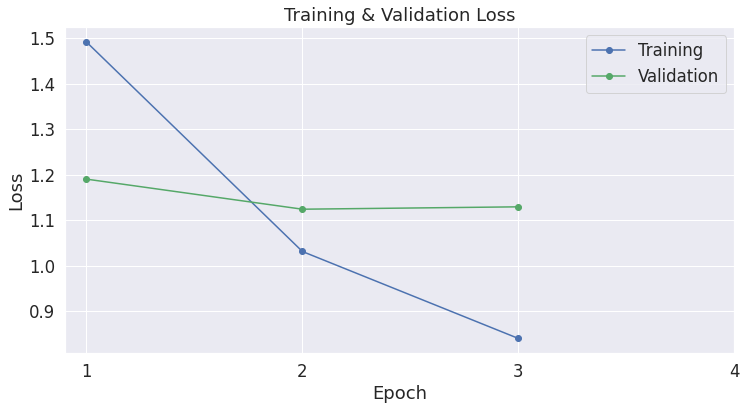

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2,3,4])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using the classification report


### 5.1. Data Preparation

We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv('test.csv',encoding='latin1', header=None)
df1 = df[[0,1,2]] # only columns with titles and genres and the genreid
df1.columns = ['title', 'genre', "label"]


# Report the number of sentences.
print('Number of test titles: {:,}\n'.format(df.shape[0]))

# Get the lists of titles and their label.
titles = test['title'].values # list of all titles
labels = test['label'].values # list of all genre ids

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for title in titles:
    # `encode_plus` will:
    #   (1) Tokenize the title.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        title,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test titles: 41,145



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
len(input_ids)

In [ ]:
len(attention_masks)

In [ ]:
len(labels)

## 5.2. Evaluate on Test Set


With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test titles...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 41,144 test titles...
    DONE.


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the genre (1-32) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels (genres) for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [ ]:
# compute overall accuracy, precision, recall, f1 scores
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# weighted = same as macroaveraging but with auto weights
print('Accuracy: ', accuracy_score(flat_true_labels, flat_predictions))
print('Precision: ', precision_score(flat_true_labels, flat_predictions, average='weighted', zero_division=1))
print('Recall: ', recall_score(flat_true_labels, flat_predictions, average='weighted', zero_division=1))
print('F1:', f1_score(flat_true_labels, flat_predictions, average='weighted'))

Accuracy:  0.022846587594789032
Precision:  0.7216525550295708
Recall:  0.022846587594789032
F1: 0.008417115154671353


In [ ]:
# compute precision, recall, fscore, support scores by genre
from sklearn.metrics import precision_recall_fscore_support as score

predicted = flat_predictions
y_test = flat_true_labels

# precision, recall, fscore, support separated by genre
precision, recall, fscore, support = score(y_test, predicted)

df_acc = pd.DataFrame()
df_acc['precision']=pd.Series(precision)
df_acc['recall']=pd.Series(recall)
df_acc['fscore']=pd.Series(fscore)
df_acc['support']=pd.Series(support)

print(df_acc)

    precision    recall    fscore  support
0    0.000000  0.000000  0.000000     1309
1    0.018182  0.001110  0.002092      901
2    0.000000  0.000000  0.000000     1945
3    0.000000  0.000000  0.000000      506
4    0.000000  0.000000  0.000000     2700
5    0.012760  0.526480  0.024916      642
6    0.089474  0.159304  0.114588     1494
7    0.000000  0.000000  0.000000     1768
8    0.090909  0.001036  0.002049     1930
9    0.000000  0.000000  0.000000     1833
10   0.000000  0.000000  0.000000      520
11   0.000000  0.000000  0.000000     2362
12   0.000000  0.000000  0.000000     1345
13   0.000000  0.000000  0.000000     1386
14   0.000000  0.000000  0.000000     1448
15   0.000000  0.000000  0.000000     1504
16   0.000000  0.000000  0.000000     2425
17   0.000000  0.000000  0.000000      402
18   0.000000  0.000000  0.000000      491
19   0.000000  0.000000  0.000000      705
20   0.000000  0.000000  0.000000      689
21   0.032266  0.179146  0.054683     1429
22   0.0000

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
set(y_test) - set(predicted)

{0, 2, 4, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 28, 29, 31}

In [ ]:
import sys
numpy.set_printoptions(threshold=sys.maxsize)
print(predicted)

[21  5 21  5 21  5 21  5  5  5  5  5  5  6 21  5 21  5  5  5 21 21 21 21
  5  5  5 21  5 21  5  5  5 21 24 21  5 21  5 21  5 21  5 21  5  5  5  5
  5 21 21 21 21  6 21 27 21  5 21 21  5 21  5  5 21  5  5 21 21 21  5 21
 21  5 21  5  5 24  5  5  5  5 24  5  5 21 21 21 21 24 21 21 21  5  5  6
 21  5  5 21 21  5  5 21  5 21  5  5 21 21  6 21 24 21  6  6 21  5 21  6
  5  5  5 24  5  5  5  5  5 24  5  5 24  5 21  5  5  5  5 21 27 21 21 24
 21  5 21  5 21  5 21 21 21  5 21  5 21  5  5  5  5  5 21  5 21 21 21 21
  5 21 21  5  5  5  5  5 21  5  5  5  5  5  5 27 21  5  5 27  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  6 27 27  5  5  5 21 21 21 21  5  5
 21  5  5 21 21 21  6 21 21  5  5 21  5 21 21  5  5 21 21  5 21  5  5  5
 21  5  6  5  5 21 21  5  5 21  6  5 21  5 24 21 21 21  5  5 21 21 21  5
 21  5 21  5  5 21  5  5  5  5 21  6 21 21  5  5 21  6  5  5 21 21  5 27
 21 21  5 21  5  5  5 21  5  5  5 21  5  5 24  5  5 21 21  5  5  5 21 21
  5  5 21  5 21  5  5  5  5 21  5  5  5 27  5  5  5

In [ ]:
len(predicted)

41144

In [ ]:
print(predictions)

[array([[-0.03202307, -0.10022597,  0.17171776, ..., -0.013299  ,
         0.43724972, -0.2925826 ],
       [-0.20227641,  0.22762516,  0.02042513, ..., -0.01383805,
         0.38394156, -0.41354752],
       [-0.14460738,  0.19641022,  0.33200866, ...,  0.12969175,
         0.46396947, -0.43760747],
       ...,
       [-0.13927853,  0.16469775,  0.2232519 , ...,  0.05916233,
         0.42667246, -0.44402158],
       [-0.17435396,  0.06948605, -0.01150782, ..., -0.09928405,
         0.4132985 , -0.29484993],
       [-0.18671957,  0.31531185, -0.13122243, ..., -0.10770999,
         0.46629   , -0.40488815]], dtype=float32), array([[-0.21372078,  0.30481878, -0.02625196, ..., -0.02755062,
         0.37538218, -0.3848943 ],
       [-0.18361446,  0.08034152,  0.3355352 , ...,  0.13282318,
         0.45435315, -0.30633825],
       [-0.16678868,  0.0713131 ,  0.4110636 , ...,  0.18005283,
         0.4308983 , -0.22462651],
       ...,
       [-0.21225995,  0.29575163,  0.33819306, ...,  0.075

In [ ]:
*while True:pass